# Plug and Play with Deep Denoiser Prior

#### Imports

In [1]:
import os
import random
import math
import numpy as np
import matplotlib.pyplot as plt

from skimage.io import imread, imsave

import torch
from torchmetrics.image import TotalVariation
from torchmetrics.functional.image import image_gradients

from forward.degradation import *
from forward.degradation import forward
from drunet.network_unet import UNetRes as net

from collections import OrderedDict
import cv2
from torchvision.transforms.functional import gaussian_blur

#### Utils for CNN

In [2]:
def mkdir(path):
    if not os.path.exists(path):
        os.makedirs(path)

In [3]:
IMG_EXTENSIONS = ['.jpg', '.JPG', '.jpeg', '.JPEG', '.png', '.PNG', '.ppm', '.PPM', '.bmp', '.BMP', '.tif']


def is_image_file(filename):
    return any(filename.endswith(extension) for extension in IMG_EXTENSIONS)

def _get_paths_from_images(path):
    assert os.path.isdir(path), '{:s} is not a valid directory'.format(path)
    images = []
    for dirpath, _, fnames in sorted(os.walk(path)):
        for fname in sorted(fnames):
            if is_image_file(fname):
                img_path = os.path.join(dirpath, fname)
                images.append(img_path)
    assert images, '{:s} has no valid image file'.format(path)
    return images

def get_image_paths(dataroot):
    paths = None  # return None if dataroot is None
    if dataroot is not None:
        paths = sorted(_get_paths_from_images(dataroot))
    return paths

In [4]:
def imread_uint(path, n_channels=3):
    #  input: path
    # output: HxWx3(RGB or GGG), or HxWx1 (G)
    if n_channels == 1:
        img = cv2.imread(path, 0)  # cv2.IMREAD_GRAYSCALE
        print('Dynamic Range of img_H = [{},{}]'.format(img.min(), img.max()))
        img = np.expand_dims(img, axis=2)  # HxWx1
    elif n_channels == 3:
        img = cv2.imread(path, cv2.IMREAD_UNCHANGED)  # BGR or G
        if img.ndim == 2:
            img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)  # GGG
        else:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # RGB
    return img

In [5]:
def uint2single(img):
    return np.float32(img/255.)

def single2uint(img):

    return np.uint8((img.clip(0, 1)*255.).round())

# convert torch tensor to single
def tensor2single(img):
    img = img.data.squeeze().float().clamp_(0, 1).cpu().numpy()
    if img.ndim == 3:
        img = np.transpose(img, (1, 2, 0))

    return img

# convert single (HxWx1, HxW) to 2-dimensional torch tensor
def single2tensor2(img):
    return torch.from_numpy(np.ascontiguousarray(img)).squeeze().float()

# convert single (HxWxn_channels) to 4-dimensional torch tensor (1, 1, H, W)
def single2tensor4(img):
        #np.ascontiguousarray(img) guarda todas las entradas de la red en lugares adyacentes en memoria
        #permute changes dimension order (600, 800, 1) --> (1, 600, 800)
        #float() transform data type to float type
        #unsqueeze adds dimension on specified axis (1, 600, 800) --> (1, 1, 600, 800)
    return torch.from_numpy(np.ascontiguousarray(img)).permute(2, 0, 1).float().unsqueeze(0)

# convert torch tensor to uint
def tensor2uint(img):
    img = img.data.squeeze().float().clamp_(0, 1).cpu().numpy()
    if img.ndim == 3:
        img = np.transpose(img, (1, 2, 0))
    return np.uint8((img*255.0).round())

In [6]:
def imshow(x, title=None, cbar=False, figsize=None):
    plt.figure(figsize=figsize)
    plt.imshow(np.squeeze(x), interpolation='nearest', cmap='gray')
    if title:
        plt.title(title)
    if cbar:
        plt.colorbar()
    plt.show()

def imsave(img, img_path):
    img = np.squeeze(img)
    if img.ndim == 3:
        img = img[:, :, [2, 1, 0]]
    cv2.imwrite(img_path, img)

In [7]:
# PSNR
def calculate_psnr(img1, img2, border=0):
    # img1 and img2 have range [0, 255]
    if not img1.shape == img2.shape:
        raise ValueError('Input images must have the same dimensions.')
    h, w = img1.shape[:2]
    img1 = img1[border:h-border, border:w-border]
    img2 = img2[border:h-border, border:w-border]

    img1 = img1.astype(np.float64)
    img2 = img2.astype(np.float64)
    mse = np.mean((img1 - img2)**2)
    if mse == 0:
        return float('inf')
    return 20 * math.log10(255.0 / math.sqrt(mse))

# SSIM
def ssim(img1, img2):
    C1 = (0.01 * 255)**2
    C2 = (0.03 * 255)**2

    img1 = img1.astype(np.float64)
    img2 = img2.astype(np.float64)
    kernel = cv2.getGaussianKernel(11, 1.5)
    window = np.outer(kernel, kernel.transpose())

    mu1 = cv2.filter2D(img1, -1, window)[5:-5, 5:-5]  # valid
    mu2 = cv2.filter2D(img2, -1, window)[5:-5, 5:-5]
    mu1_sq = mu1**2
    mu2_sq = mu2**2
    mu1_mu2 = mu1 * mu2
    sigma1_sq = cv2.filter2D(img1**2, -1, window)[5:-5, 5:-5] - mu1_sq
    sigma2_sq = cv2.filter2D(img2**2, -1, window)[5:-5, 5:-5] - mu2_sq
    sigma12 = cv2.filter2D(img1 * img2, -1, window)[5:-5, 5:-5] - mu1_mu2

    ssim_map = ((2 * mu1_mu2 + C1) * (2 * sigma12 + C2)) / ((mu1_sq + mu2_sq + C1) *
                                                            (sigma1_sq + sigma2_sq + C2))
    return ssim_map.mean()


def calculate_ssim(img1, img2, border=0):
    '''calculate SSIM
    the same outputs as MATLAB's
    img1, img2: [0, 255]
    '''
    if not img1.shape == img2.shape:
        raise ValueError('Input images must have the same dimensions.')
    h, w = img1.shape[:2]
    img1 = img1[border:h-border, border:w-border]
    img2 = img2[border:h-border, border:w-border]

    if img1.ndim == 2:
        return ssim(img1, img2)
    elif img1.ndim == 3:
        if img1.shape[2] == 3:
            ssims = []
            for i in range(3):
                ssims.append(ssim(img1, img2))
            return np.array(ssims).mean()
        elif img1.shape[2] == 1:
            return ssim(np.squeeze(img1), np.squeeze(img2))
    else:
        raise ValueError('Wrong input image dimensions.')


#### Load CNN model

In [8]:
# load model
model_path = os.path.join('./drunet/drunet_gray.pth')
model = net(in_nc=1+1, out_nc=1, nc=[64, 128, 256, 512], nb=4, act_mode='R', downsample_mode="strideconv", upsample_mode="convtranspose", bias = False)
model.load_state_dict(torch.load(model_path), strict=True)
model.eval()
for _, v in model.named_parameters():
    v.requires_grad = False

#### Data term optimization functions

In [9]:
def get_rho_sigma(sigma=2.55/255, iter_num=15, modelSigma1=49.0, modelSigma2=2.55, w=1.0):
    '''
    One can change the sigma to implicitly change the trade-off parameter
    between fidelity term and prior term
    '''
    # iter_num decreasing values in logarithmic scale in range [10^2.55, 10^49]
    modelSigmaS = np.logspace(np.log10(modelSigma1), np.log10(modelSigma2), iter_num).astype(np.float32)
    modelSigmaS_lin = np.linspace(modelSigma1, modelSigma2, iter_num).astype(np.float32)
    sigmas = (modelSigmaS*w + modelSigmaS_lin*(1-w))/255.
    # trade off parameter lambda fixed at 0.23
    alphas = list(map(lambda x: 0.23*(sigma**2)/(x**2), sigmas))
    return alphas, sigmas

In [ ]:
def apply_degradation(degradation = 'hdmi', x, sigma = 10/255):
    # choose between hdmi degradation or gaussian blur degradation
    if degradation == 'hdmi':
        T_x = forward(x)
        return T_x
    elif degradation == 'blur':
        x_copy = x.clone()
        x_copy = x_copy.unsqueeze(0)
        T_x = gaussian_blur(x_copy, kernel_size = (5,5), sigma = sigma)
        T_x = T_x.squeeze(0)
        return T_x

In [ ]:
# calculate objective function
def data_term_objective_function(degradation, x, y_obs, z_prev, alpha, sigma):
    """
    Inputs:
    degradation (char): 'hdmi' for HDMI degradation function. 'blur' for gaussian blur degradation function.
    x (torch tensor shape [H,W]): image to apply degradation function.
    y_obs (torch tensor shape [H,W]): output of degradation function with added noise when input is x_gt.
    z_prev (torch tensor shape [H,W]): output of denoiser prior. [0, 1] Dynamic Range.
    alpha (float): regularization hyperparameter at iteration k.

    Output:
    objective_function_value (float): value of the objective function.
    """
    
    # normalize x input
    x_copy = x.detach().clone() 
    x_min = torch.min(x_copy)
    x_max = torch.max(x_copy)
    x = (x_copy - x_min) / (x_max - x_min)

    # apply degradation function
    T_x = apply_degradation(degradation, x, sigma)

    # calculate objective function at k iteration
    obj_function = torch.norm(y_obs - T_x)**2 + alpha*torch.norm(x - z_prev)**2

    return obj_function

In [11]:
def optimize_data_term(degradation, x_gt, z_k_prev, x_0, y_obs, alpha, i, max_iter = 5000, eps = 1e-4, lr = 0.1, k_print = 1, plot = True):
    """
    Inputs:
    degradation (char): 'hdmi' for HDMI degradation function. 'blur' for gaussian blur degradation function.
    x_gt (torch tensor shape [H,W]): ground truth image. [0, 1] Dynamic Range.
    z_i_prev (torch tensor shape [H,W]): output of denoiser prior. [0, 1] Dynamic Range.
    x_0 (torch tensor shape [H,W]): initial condition image with parameter 'requires_grad = True'. [0,1] Dynamic range.
    y_obs (torch tensor shape [H,W]): output of degradation function with added noise when input is x_gt.
    alpha (float): hyperparameter of data term optimization.
    i (int): iteration number of Plug and Play optimization.
    max_iter (int): maximum number of iterations.
    eps (float): minimum tolerance for algorithm to stop.
    lr (float): learning rate of iterative algorithm.
    k_print (int): print results for multiples of k_print iterations.
    plot (boolean): if True, plot OF_record, diff_x_record and diff_x_gt_record.

    Output:
    x_opt (torch tensor shape [H,W]): image result of optimizing objective function. [0, 1] Dynamic Range.  
    """

    # store |x^{k+1} - x^{k}| 
    diff_x = torch.inf
    diff_x_record = []
    
    # store |x^{k} - x_gt| 
    diff_x_gt = torch.inf
    diff_x_gt_record = []

    # store objective function values at step k
    OF_record = []
    
    x_opt = x_0.detach()

    x_opt.requires_grad = True

    # print initial condition image x_0
    plt.figure(figsize = (10,8))
    plt.imshow(x_opt.detach(), cmap = 'gray')
    plt.title('Data term initial condition x_0')
    plt.show()

    # define optimizer
    optimizer = torch.optim.Adam([x_opt], lr=lr)
    
    k = 0
    while (k < max_iter) and (diff_x_gt > eps):

        x_prev = x_opt.detach().clone()
        
        # empty gradients
        optimizer.zero_grad()
        # calculate objective function
        objective_func = data_term_objetive_function(degradation, x_opt, y_obs, z_k_prev, alpha, k, sigma)
        # backpropagation of gradients
        objective_func.backward(retain_graph=True)
        # update x_opt
        optimizer.step()

        OF_record.append(objective_func.detach())

        x_next = x_opt.detach().clone()

        diff_x = torch.norm(x_next - x_prev).detach()
        diff_x_record.append(diff_x)

        diff_x_gt = torch.norm(x_next - x_gt).detach()
        diff_x_gt_record.append(diff_x_gt)

        print("k: {}".format(k), end="\r", flush=True)
        k = k + 1

        if (k % k_print == 0):
            
            print("k: {}".format(k), end="\r", flush=True)
            print('objective function = {}'.format(objective_func))
            print('diff_x_gt: {}'.format(diff_x_gt))
            print('diff_x: {}'.format(diff_x))
            print('-----------')

            plt.figure(figsize = (10,8))
            plt.imshow(x_opt.detach().numpy(), cmap = 'gray')
            plt.title('x_opt')
            plt.show()

            # normalize x input
            x_copy = x.detach().clone() 
            x_min = torch.min(x_copy)
            x_max = torch.max(x_copy)
            x = (x_copy - x_min) / (x_max - x_min)

            y_opt = apply_degradation(degradation, x, sigma)
            y_opt_abs = y_opt.abs()
            y_opt_show = (y_opt_abs - y_opt_abs.min()) / (y_opt_abs.max() - y_opt_abs.min())
            
            y_obs_show = (y_obs_abs - y_obs_abs.min()) / (y_obs_abs.max() - y_obs_abs.min())

            _, axes = plt.subplots(1, 2, figsize=(12, 10))
            axes[0].imshow(y_opt_show.detach().numpy(), cmap = 'gray')
            axes[0].set_title("T(x_k). Iteration = {}".format(k))
            axes[1].imshow(y_obs_show.detach().numpy(), cmap = 'gray')
            axes[1].set_title("y_obs")
            plt.tight_layout()
            plt.show()
        
            plt.tight_layout()
            plt.show()
    
    if plot:
        inicio = 0

        plt.figure(figsize = (7,5))
        plt.plot(OF_record[inicio:], 'r')
        plt.grid()
        plt.title('Objective Function')
        plt.show()

        plt.figure(figsize = (7,5))
        plt.plot(diff_x_gt_record[inicio:], 'b')
        plt.grid()
        plt.title('|x^k - x_gt|')
        plt.show()

        plt.figure(figsize = (7,5))
        plt.plot(diff_x_record[inicio:], 'g')
        plt.grid()
        plt.title('|x_k+1 - x_k|')
        plt.show()

    x_opt_max = torch.max(x_opt)
    x_opt_min = torch.min(x_opt)
    x_opt = (x_opt - x_opt_min) / (x_opt_max - x_opt_min)
    
    return x_opt

#### Plug and Play optimization

In [ ]:
# import image dynamic range test
x_gt = torch.tensor(imread("./images/VAMO.png", as_gray=True), requires_grad= True)
print('Dynamic range of image is [{},{}]'.format(x_gt.min(), x_gt.max()))

# forward dynamic range test
y = forward(x_gt)
y_abs = y.abs()
print('Dynamic range of forward image is [{},{}]'.format(y_abs.min(), y_abs.max()))

In [13]:
def observation(degradation, x, noise_level_img):
    y = apply_degradation(degradation, x, sigma)
    np.random.seed(seed=0)
    y = y + torch.normal(mean = 0, std = noise_level_img, size = (y.shape[0], y.shape[1]))
    return y

In [14]:
def plug_and_play_optimization(degradation, x_gt, z_0, x_0, noise_level_img, modelSigma1, modelSigma2, num_iter = 5000, max_iter_data_term = 1000,  eps_data_term = 1e-4, lr = 0.1, k_print_data_term = 10):
    """
    Inputs:
    degradation (char): 'hdmi' for HDMI degradation function. 'blur' for gaussian blur degradation function.
    x_gt (torch tensor shape [H,W]): ground truth image. [0,1] Dynamic range.
    z_0 (torch tensor shape [H,W]): initial condition image for Plug and Play algorithm. [0,1] Dynamic range.
    x_0 (torch tensor shape [H,W]): initial condition image with parameter 'requires_grad = True' for data term optimization subproblem. [0,1] Dynamic range.
    noise_level_img (float): image noise level.
    modelSigma1 (float): upper bound of noise level interval for sigma_k.
    modelSigma2 (float): lower bound of noise level interval for sigma_k.
    num_iter (int): number of iterations of Plug and Play algorithm.
    max_iter_data_term (int): maximum number of iterations for data term optimization subproblem.
    eps_data_term (int): minimum tolerance for data term optimization subproblem to stop.
    lr (float): learning rate of data term optimization subproblem.
    k_print_data_term (int): print results for multiples of k_print_data_term iterations.

    Output:
    x_opt (torch tensor shape [H,W]): image result of optimizing objective function. [0,1] Dynamic range.
    """

    # store |z^{k+1} - z^{k}| 
    diff_z = torch.inf
    diff_z_record = []
    
    # store |z^{k} - x_gt| 
    diff_x_gt = torch.inf
    diff_x_gt_record = []
    
    # print initial condition image z_0
    plt.figure(figsize = (10,8))
    plt.imshow(z_0.detach(), cmap = 'gray')
    plt.title('Initial condition z_0')
    plt.show()

    z_opt = z_0 

    noise_level_model = noise_level_img   

    # generate observation y_obs
    y_obs = observation(degradation, x_gt, noise_level_model)

    # precalculation of parameters for each iteration
    alphas, sigmas = get_rho_sigma(sigma=max(0.255/255., noise_level_model), iter_num = num_iter, modelSigma1 = modelSigma1, modelSigma2 = modelSigma2, w = 1.0)
    alphas, sigmas = torch.tensor(alphas), torch.tensor(sigmas)

    # iterate algorithm num_iter times
    for i in range(num_iter):
        
        z_prev = z_opt.detach().clone()

        # optimize data term
        x_i = optimize_data_term(degradation, x_gt, z_opt, x_0, y_obs, alpha = alphas[i], i, max_iter = max_iter_data_term, eps = eps_data_term, lr = lr, k_print = k_print_data_term, plot = True)
        # output of optimize_data_term is float32 [H,W] array in range [0.0, 1.0]
        print('Dynamic Range of output at iteration {} of optimize_data_term = [{}, {}]'.format(i, x_i.min(), x_i.max()))

        # adjust dimensions
        x_i = x_i.detach().numpy()
        # [H,W] --> [H, W, 1]
        x_i = np.expand_dims(x_i, axis=2)
        x_i_dim4 = single2tensor4(x_i)
        x_i_dim4 = torch.cat((x_i_dim4, torch.FloatTensor([sigmas[i]]).repeat(1, 1, x_i_dim4.shape[2], x_i_dim4.shape[3])), dim=1)

        # forward denoiser model
        print('Enter Forward. Iteration {}'.format(i))
        z_opt = model(x_i_dim4)
        z_opt = z_opt[0,0,:,:]
        print('Dynamic Range of output of cnn at iteration {} is [{}, {}]'.format(i, z_opt.min(), z_opt.max()))
        
        # normalize z_opt between [0, 1]. [H,W]
        min_z_opt = z_opt.min()
        max_z_opt = z_opt.max()
        z_opt = (z_opt - min_z_opt)/(max_z_opt - min_z_opt)
        print('Dynamic Range of z_opt after normalize at iteration {} is [{}, {}]'.format(i, z_opt.min(), z_opt.max()))

        # print output of denoiser model
        plt.figure(figsize = (10, 6))
        plt.imshow(z_opt, cmap = 'gray')
        plt.title('Output of denoiser at iteration {}'.format(i))
        plt.show()

        z_next = z_opt.detach().clone()
        
        diff_z = torch.norm(z_next - z_prev).detach()
        diff_z_record.append(diff_z)

        diff_x_gt = torch.norm(z_next - x_gt).detach()
        diff_x_gt_record.append(diff_x_gt)

    plt.figure(figsize = (7,5))
    plt.plot(diff_x_gt_record, 'b')
    plt.grid()
    plt.title('|z^i - x_gt|')
    plt.show()

    plt.figure(figsize = (7,5))
    plt.plot(diff_z_record, 'g')
    plt.grid()
    plt.title('|z_i+1 - z_i|')
    plt.show()

    return z_opt

In [ ]:
x_gt = torch.tensor(imread("./images/Aakur_A_Perceptual_Prediction_Framework_for_Self_Supervised_Event_Segmentation_CVPR_2019_paper.png", as_gray=True))
print('Dynamic Range of x_gt = [{},{}]'.format(x_gt.min(), x_gt.max()))

x_0 = torch.tensor(imread("./images/Aakur_A_Perceptual_Prediction_Framework_for_Self_Supervised_Event_Segmentation_CVPR_2019_paper/Aakur_A_Perceptual_Prediction_Framework_for_Self_Supervised_Event_Segmentation_CVPR_2019_paper_5.png", as_gray=True))
x_0 = torch.tensor(uint2single(x_0), requires_grad = True)
print('Dynamic Range of x_0 = [{},{}]'.format(x_0.min(), x_0.max()))
z_0 = x_0

noise_level_model = 7.65/255.0
modelSigma1 = 30
modelSigma2 = 2.55
num_iter = 8
max_iter_data_term = 100
eps_data_term = 1e-4
lr = 0.1
k_print_data_term = 25

z_opt = plug_and_play_optimization(x_gt, z_0, x_0, noise_level_model, modelSigma1, modelSigma2, num_iter, max_iter_data_term, eps_data_term, lr, k_print_data_term)

In [ ]:
plt.figure(figsize = (12,8))
plt.imshow(z_opt.detach(), cmap = 'gray')
plt.show()

In [ ]:
x_gt = torch.tensor(imread("./images/Aakur_A_Perceptual_Prediction_Framework_for_Self_Supervised_Event_Segmentation_CVPR_2019_paper.png", as_gray=True))
print('Dynamic Range of x_gt = [{},{}]'.format(x_gt.min(), x_gt.max()))

x_0 = torch.tensor(imread("./images/Aakur_A_Perceptual_Prediction_Framework_for_Self_Supervised_Event_Segmentation_CVPR_2019_paper/Aakur_A_Perceptual_Prediction_Framework_for_Self_Supervised_Event_Segmentation_CVPR_2019_paper_5.png", as_gray=True))
x_0 = torch.tensor(uint2single(x_0), requires_grad = True)
print('Dynamic Range of x_0 = [{},{}]'.format(x_0.min(), x_0.max()))
z_0 = x_0

noise_level_model = 7.65/255.0
modelSigma1 = 30
modelSigma2 = 2.55
num_iter = 8
max_iter_data_term = 100
eps_data_term = 1e-4
lr = 0.01
k_print_data_term = 25

z_opt = plug_and_play_optimization(x_gt, z_0, x_0, noise_level_model, modelSigma1, modelSigma2, num_iter, max_iter_data_term, eps_data_term, lr, k_print_data_term)

In [ ]:
plt.figure(figsize = (12,8))
plt.imshow(z_opt.detach(), cmap = 'gray')
plt.show()

In [ ]:
x_gt = torch.tensor(imread("./images/VAMO.png", as_gray=True))
print('Dynamic Range of x_gt = [{},{}]'.format(x_gt.min(), x_gt.max()))

x_0 = forward(x_gt)
x_0 = x_0.abs()
print('Dynamic Range of x_0 = [{},{}]'.format(x_0.min(), x_0.max()))
z_0 = x_0

noise_level_model = 7.65/255.0
modelSigma1 = 30
modelSigma2 = 2.55
num_iter = 8
max_iter_data_term = 100
eps_data_term = 1e-4
lr = 0.1
k_print_data_term = 25

z_opt = plug_and_play_optimization(x_gt, z_0, x_0, noise_level_model, modelSigma1, modelSigma2, num_iter, max_iter_data_term, eps_data_term, lr, k_print_data_term)

In [ ]:
plt.figure(figsize = (12,8))
plt.imshow(z_opt.detach(), cmap = 'gray')
plt.show()

#### Plug and Play Test

#### Run network

In [19]:
noise_level_img = 15
noise_level_model = noise_level_img

model_name = 'drunet_gray' 
testset_name = 'tempest'

model_pool = 'model_zoo'
testsets = 'testsets'                
results = 'results'                  
task_current = 'dn'                  # 'dn' for denoising
result_name = testset_name + '_' + task_current + '_' + model_name

# L_path, for Low-quality images
L_path = os.path.join(testsets, testset_name) 
# E_path, for Estimated images
E_path = os.path.join(results, result_name)
# create folder for estimated images    
mkdir(E_path)

In [20]:
# load model
model_path = os.path.join('./drunet/drunet_gray.pth')
model = net(in_nc=1+1, out_nc=1, nc=[64, 128, 256, 512], nb=4, act_mode='R', downsample_mode="strideconv", upsample_mode="convtranspose")
model.load_state_dict(torch.load(model_path), strict=True)
model.eval()
for _, v in model.named_parameters():
    v.requires_grad = False

In [21]:
# list to store psnr and ssim metrics
test_results = OrderedDict()
test_results['psnr'] = []
test_results['ssim'] = []

Dynamic Range of img_H = [0,255]
Dynamic Range of img_L = [0.0,1.0]
Dynamic Range of img_L + noise = [-0.1999708116054535,1.252109169960022]


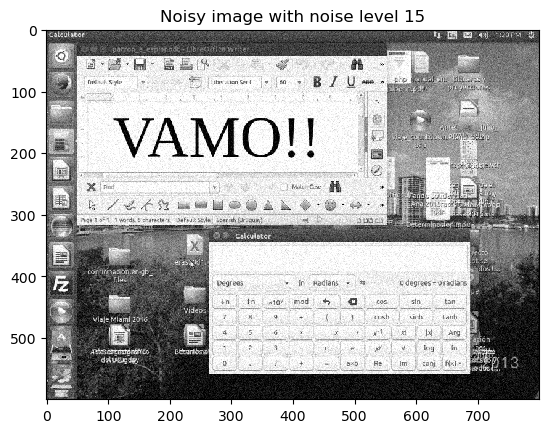

Dynamic Range of img_L + noise tensor4 = [-0.1999708116054535,1.252109169960022]
Dynamic Range of img_L + noise post cat = [-0.1999708116054535,1.252109169960022]
torch.Size([1, 1, 600, 800])
Dynamic Range of img_E = [-0.010673806071281433,1.0440425872802734]


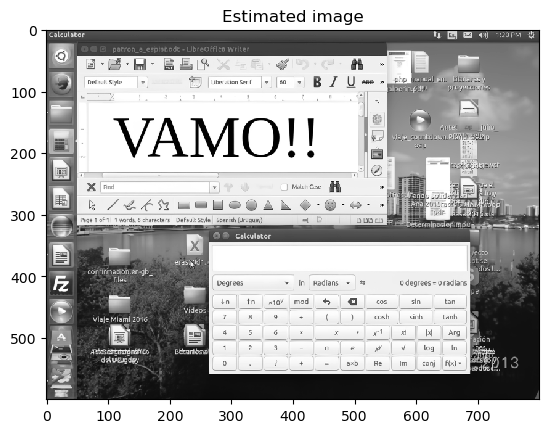

shape of img_H = (600, 800). shape of img_E = (600, 800)


In [22]:
L_paths = get_image_paths(L_path)

for idx, img in enumerate(L_paths):

    # generate low quality image L
    img_name, ext = os.path.splitext(os.path.basename(img))
    img_H = imread_uint(img, n_channels=1)
    img_L = uint2single(img_H)
    print('Dynamic Range of img_L = [{},{}]'.format(img_L.min(), img_L.max()))

    # random seed
    np.random.seed(seed=0) 
    # add AWGN 
    img_L += np.random.normal(0, noise_level_img/255., img_L.shape)
    print('Dynamic Range of img_L + noise = [{},{}]'.format(img_L.min(), img_L.max()))

    # transform float32 type to uint to show image
    imshow(single2uint(img_L), title='Noisy image with noise level {}'.format(noise_level_img))

    img_L = single2tensor4(img_L)
    print('Dynamic Range of img_L + noise tensor4 = [{},{}]'.format(img_L[0,0,:,:].min(), img_L[0,0,:,:].max()))
    img_L = torch.cat((img_L, torch.FloatTensor([noise_level_model/255.]).repeat(1, 1, img_L.shape[2], img_L.shape[3])), dim=1)
    print('Dynamic Range of img_L + noise post cat = [{},{}]'.format(img_L[0,:,:,:].min(), img_L[0,:,:,:].max()))

    #img_E is the prediction of the cnn
    img_E = model(img_L)
    print(img_E.shape)
    print('Dynamic Range of img_E = [{},{}]'.format(img_E[0,0,:,:].min(), img_E[0,0,:,:].max()))

    img_E = tensor2uint(img_E)
    imshow(img_E, title='Estimated image')

    #calculate PSNR and SSIM metric
    img_H = img_H.squeeze() 
    print('shape of img_H = {}. shape of img_E = {}'.format(img_H.shape, img_E.shape))
    psnr = calculate_psnr(img_E, img_H, border=0)
    ssim = calculate_ssim(img_E, img_H, border=0)
    test_results['psnr'].append(psnr)
    test_results['ssim'].append(ssim)

    #save estimated image on E_path
    imsave(img_E, os.path.join(E_path, img_name+ext))